## imports

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ux6wnjn8
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-ux6wnjn8
  Resolved https://github.com/albu/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=9659d6a10f0da79111bf68c237bbce96c1e5996e5b85a2f93ec8993a2a064d15
  Stored in directory: /tmp/pip-ephem-wheel-cache-250yw707/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, h

# let**'s go to load our data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd ./gdrive/MyDrive/PV01_new

/content/gdrive/MyDrive/PV01_new


In [ ]:
ls

'1682643405952?e=1686787200&v=beta&t=31OiUuMdno3jkD2wF0T3wavXD2SRkeCsB-d8wJm5ebE'
 best_model1.h5
 best_model2.h5
 best_model_psp1.h5
'download (1).jpg'
'download (2).jpg'
'download (3).jpg'
'download (4).jpg'
 download.jpg
 test.jpeg
 test_mask/
 test_non_mask/
 train_mask/
 train_non_mask/
'url?sa=i&url=https:%2F%2Fwww.alamy.com%2Ftop-view-of-a-house-with-solar-panels-on-roof-of-home-regenerative-energy-system-electricity-generation-image265102841.html&psig=AOvVaw1haVanCmTflIADjChqoqW3&ust=1684655694593000&source=images&cd'
 val_mask/
 val_non_mask/


lets define some helper functions

In [ ]:
def visualize(**images):
  #this function will be used to show the images and masks
  n=len(images)
  plt.figure(figsize=(16,5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

In [ ]:
def normalizer(x):
  #this function normalize image in range of 0 and 1 for better visualization
  x_max = np.percentile(x, 98)
  x_min = np.percentile(x, 2)
  x = (x - x_min) / (x_max - x_min)
  x = x.clip(0, 1)
  return x

lets add some oop to our code
class dataset is used to load our dataset and do some preprocessing stuffs like normalization and some augementations like flip etc

In [ ]:
class Dataset:
  CLASSES = ['solar_panel']
  def __init__(
    self,
    dir_im,
    dir_mask,
    classes=None,
    augmentation=None,
    preprocessing=None
  ):
    self.ids=os.listdir(dir_im)
    self.images_fps= [os.path.join(dir_im, image_id) for image_id in self.ids]
    self.masks_fps= [os.path.join(dir_mask, image_id.split('.')[0]+'_label.bmp') for image_id in self.ids]
    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    self.augmentation = augmentation
    self.preprocessing = preprocessing
  def __getitem__(self, i):

    # read data
    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i],0)
    mask=cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype('float')

    # add background if mask is not binary
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    return image, mask
  def __len__(self):
    return len(self.ids)



lets make a dataloader this class loads data and shuffle it for making epoches

In [ ]:
class Dataloader(tf.keras.utils.Sequence):


    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# here we go for data augmuntation , augmuntation is a technique to tackle the challenge of small dataset in this technique we use different transformations on dataset to train more redundant neural network . here we use albumentation library to apply our transforms

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.GaussNoise(p=0.2),
        #A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    #sometimes 48
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):


    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

# segmentation models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
ls

'1682643405952?e=1686787200&v=beta&t=31OiUuMdno3jkD2wF0T3wavXD2SRkeCsB-d8wJm5ebE'
 best_model1.h5
 best_model2.h5
 best_model_psp1.h5
'download (1).jpg'
'download (2).jpg'
'download (3).jpg'
'download (4).jpg'
 download.jpg
 test.jpeg
 test_mask/
 test_non_mask/
 train_mask/
 train_non_mask/
'url?sa=i&url=https:%2F%2Fwww.alamy.com%2Ftop-view-of-a-house-with-solar-panels-on-roof-of-home-regenerative-energy-system-electricity-generation-image265102841.html&psig=AOvVaw1haVanCmTflIADjChqoqW3&ust=1684655694593000&source=images&cd'
 val_mask/
 val_non_mask/


In [ ]:

x_train_dir = os.path.join('train_non_mask')
y_train_dir = os.path.join('train_mask')

x_valid_dir = os.path.join('val_non_mask')
y_valid_dir = os.path.join('val_mask')

x_test_dir = os.path.join('test_non_mask')
y_test_dir = os.path.join('test_mask')

we use 2 different backbones(pretrained models) to encoder part of u net
1. 'mobilenetv2'
2. 'efficientnetb3'

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['solar_panel']
LR = 0.0001
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)

44107200/44107200 [==============================] - 1s 0us/step


we use cobination of focal loss and dice loss for our model that is better choice than simple binary crossentropy

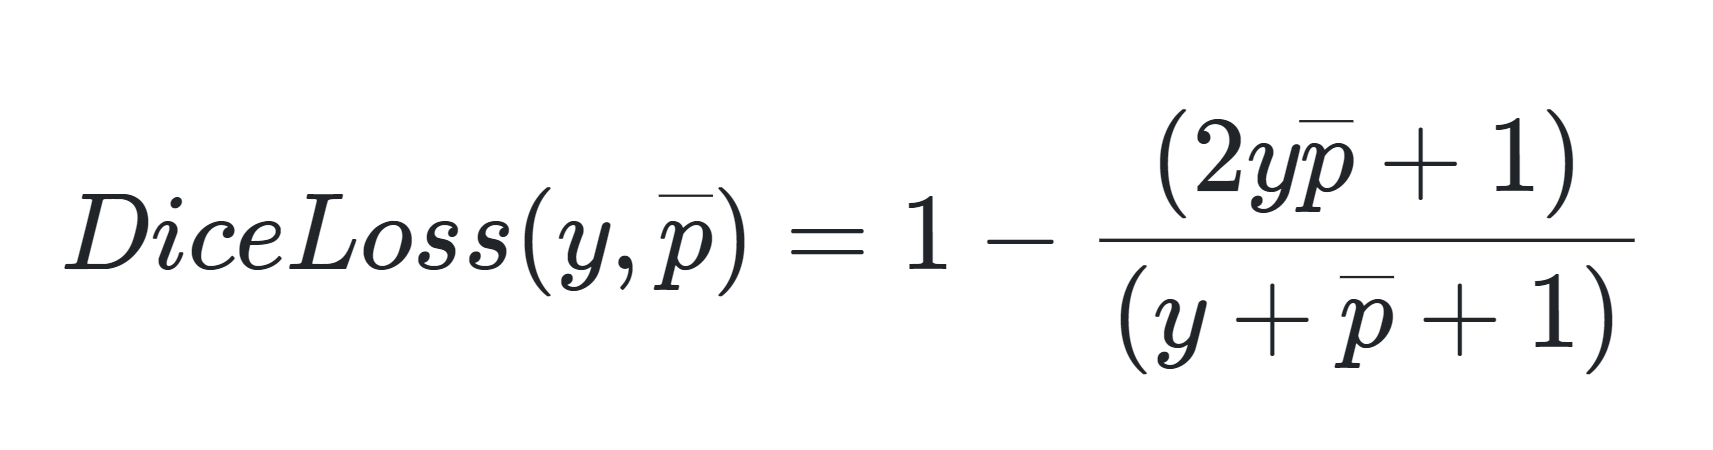

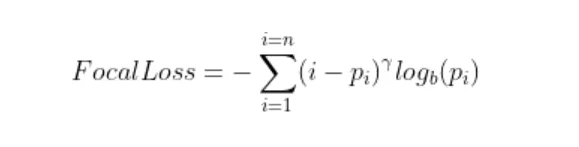

In [ ]:
# define optimizer
optim = tf.keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256,256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_fpn1.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
model?

In [ ]:

# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=5,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)


Epoch 1/5
57/57 [==============================] - 2274s 39s/step - loss: 0.2926 - iou_score: 0.7417 - f1-score: 0.8433 - val_loss: 0.1776 - val_iou_score: 0.8452 - val_f1-score: 0.9072 - lr: 1.0000e-04
Epoch 2/5
57/57 [==============================] - 2103s 37s/step - loss: 0.1868 - iou_score: 0.8395 - f1-score: 0.9091 - val_loss: 0.3261 - val_iou_score: 0.7965 - val_f1-score: 0.8647 - lr: 1.0000e-04
Epoch 3/5
57/57 [==============================] - 2154s 38s/step - loss: 0.1666 - iou_score: 0.8628 - f1-score: 0.9229 - val_loss: 0.1649 - val_iou_score: 0.8712 - val_f1-score: 0.9221 - lr: 1.0000e-04
Epoch 4/5
57/57 [==============================] - 2173s 38s/step - loss: 0.1349 - iou_score: 0.8868 - f1-score: 0.9382 - val_loss: 0.1618 - val_iou_score: 0.8715 - val_f1-score: 0.9223 - lr: 1.0000e-04
Epoch 5/5
57/57 [==============================] - 2153s 38s/step - loss: 0.1089 - iou_score: 0.9098 - f1-score: 0.9514 - val_loss: 0.1485 - val_iou_score: 0.8711 - val_f1-score: 0.9226 - 

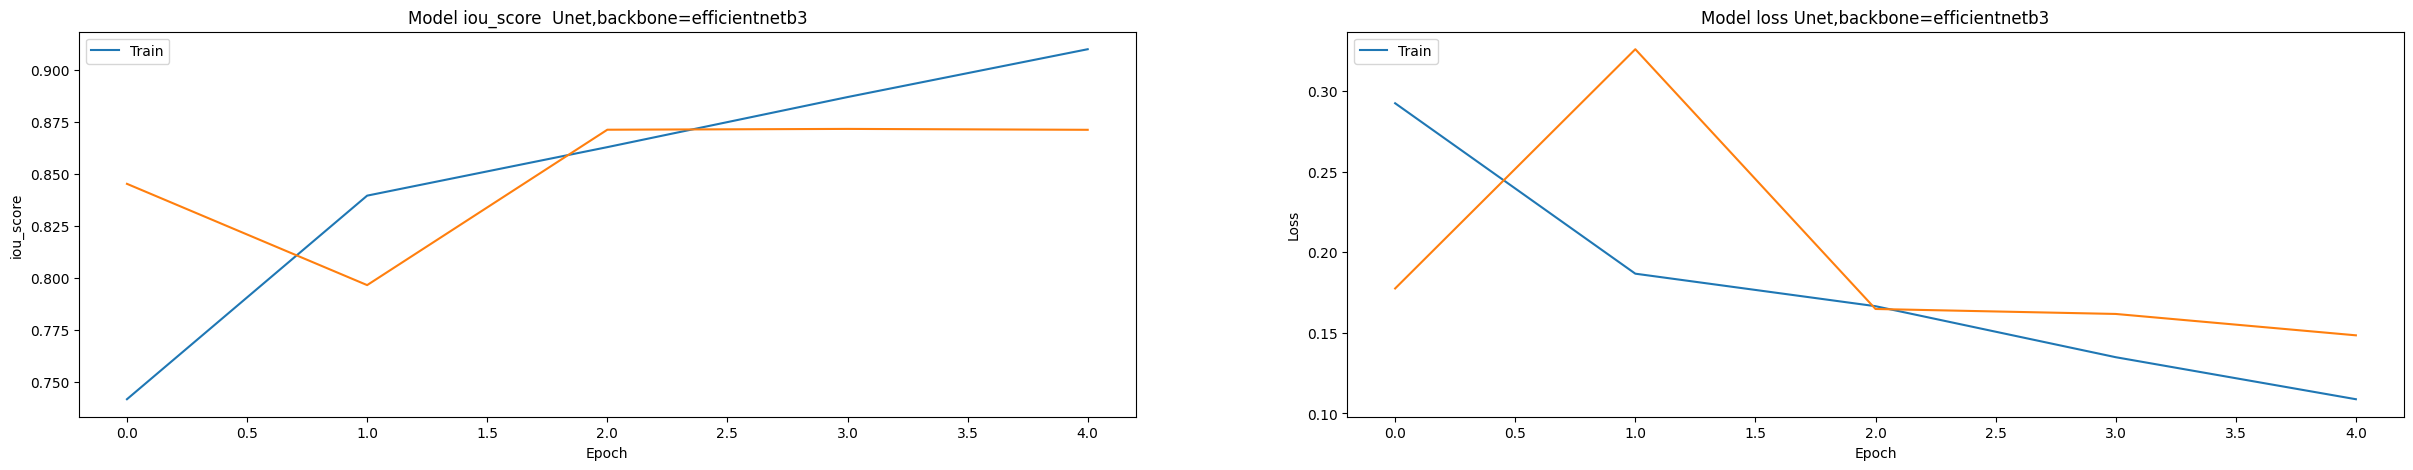

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score  Unet,backbone=efficientnetb3')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Unet,backbone=efficientnetb3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# test set performance unet+efficientb3

In [ ]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
scores = model.evaluate(test_dataloader)

print(f"Loss: {scores[0]:.5}")
for metric, value in zip(metrics, scores[1:]):
    print(f"mean {metric.__name__}: {value:.5}")

91/91 [==============================] - 102s 1s/step - loss: 0.0782 - iou_score: 0.9333 - f1-score: 0.9643
Loss: 0.078244
mean iou_score: 0.93326
mean f1-score: 0.96433


1/1 [==============================] - 5s 5s/step


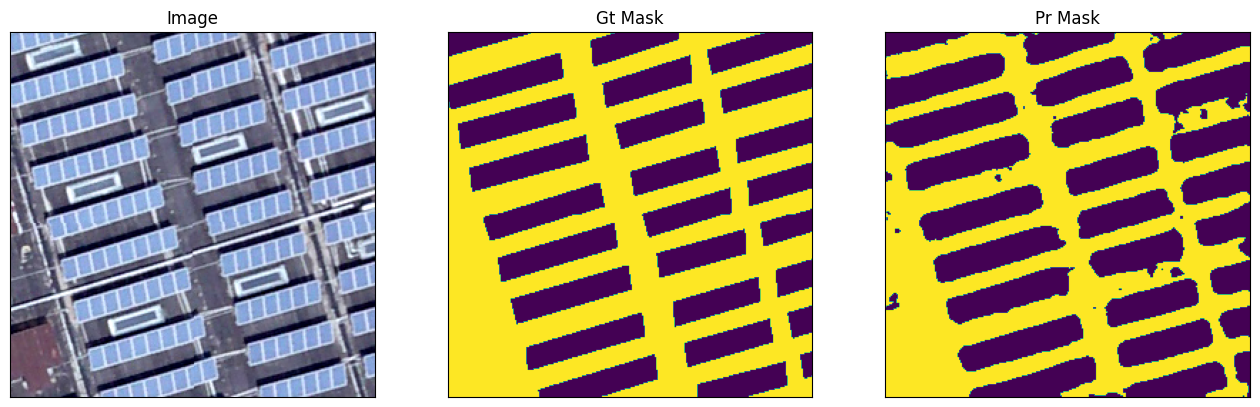

1/1 [==============================] - 1s 972ms/step


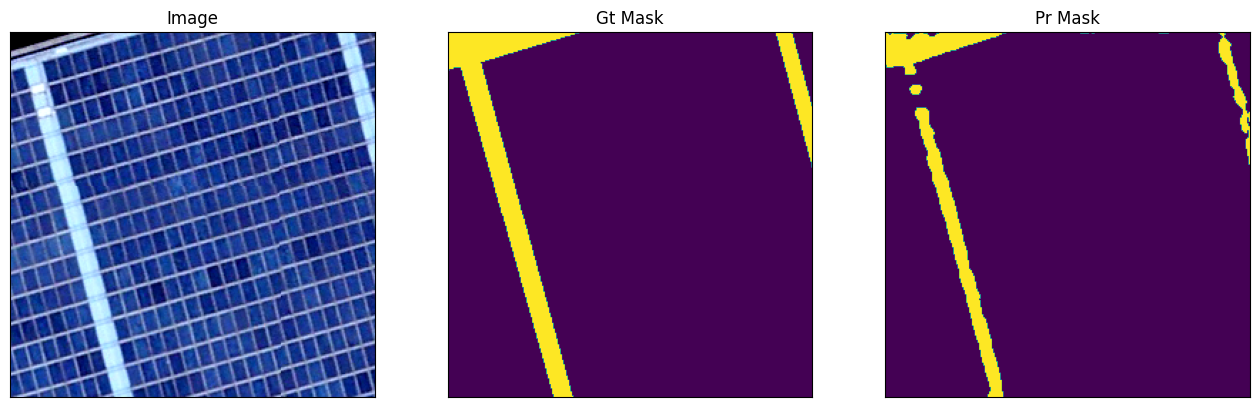

1/1 [==============================] - 1s 944ms/step


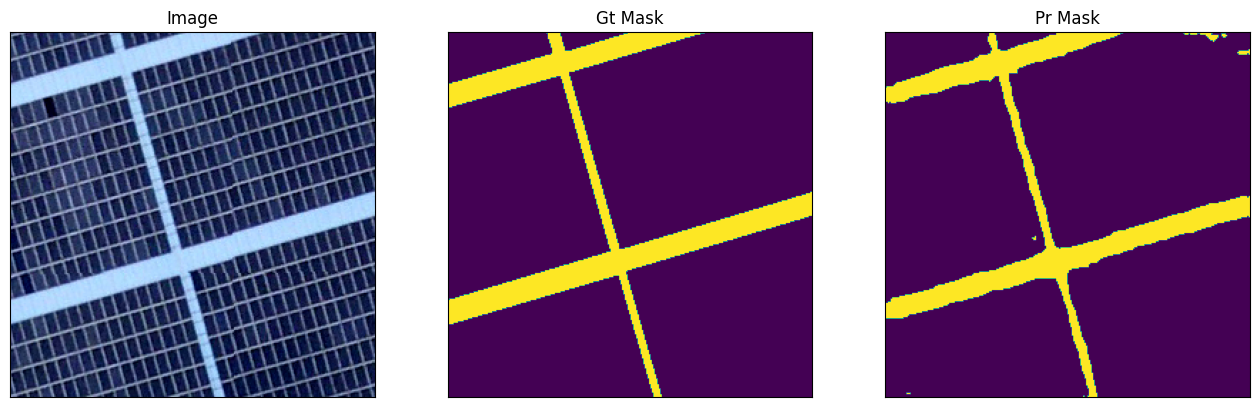

1/1 [==============================] - 2s 2s/step


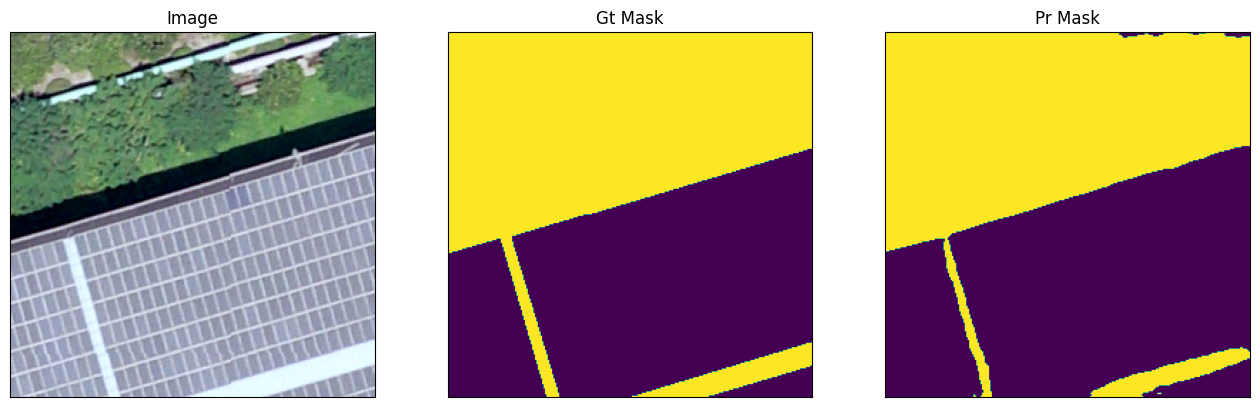

1/1 [==============================] - 1s 1s/step


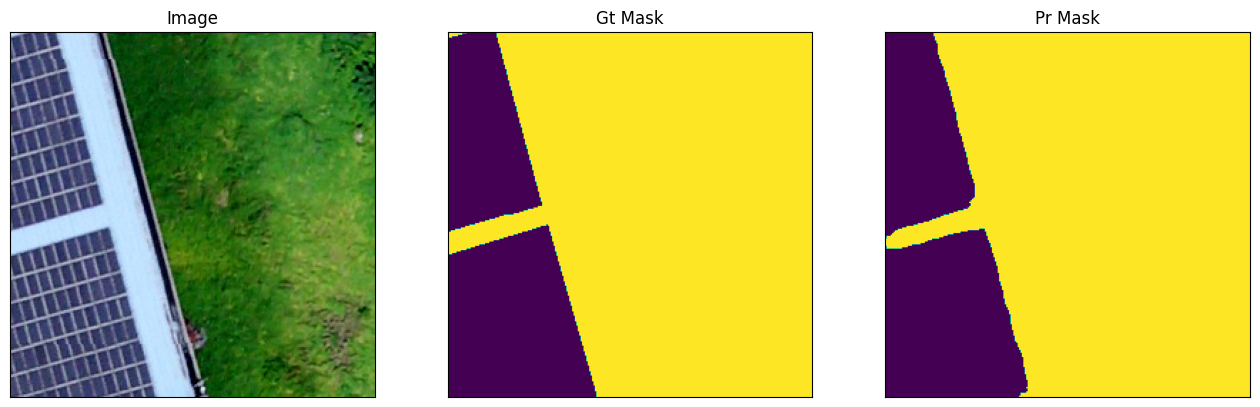

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=normalizer(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
model.load_weights('best_model_fpn1.h5')

In [ ]:
from google.colab import files
from IPython.display import Image
import imageio
import cv2
from skimage.transform import resize
from skimage.io import imsave, imread

In [ ]:
upload=files.upload()

In [ ]:
def test_function(name):
  image = imread(name)
  image = resize(image, (384, 384))
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()

  visualize(
        image=normalizer(image.squeeze()),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

1/1 [==============================] - 5s 5s/step


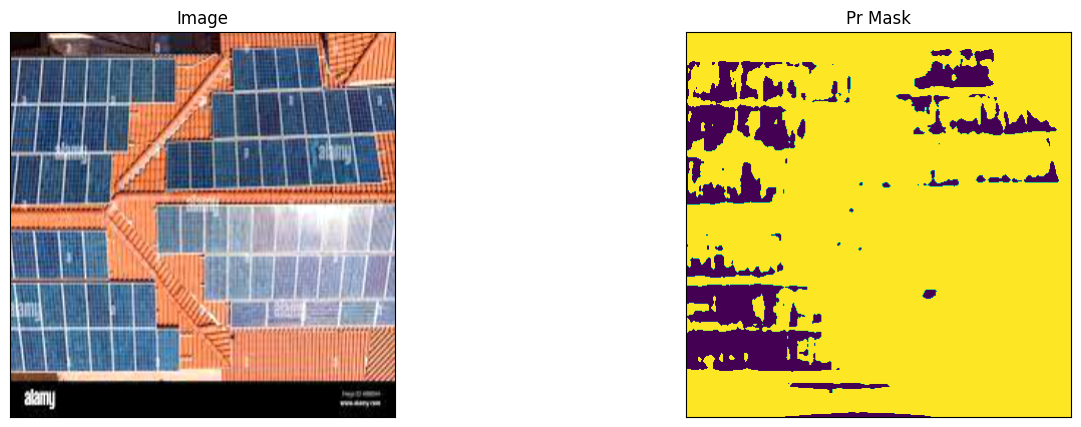

In [ ]:
test_function('download.jpg')